In [177]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [179]:
num_qubits = 4
num_layers = 2
num_samples = 200
qubits_list = [2, 3, 4]              # [2, 3, 4, 5, 6]
layers_list = [1, 2, 5]              # [1, 2, 5, 10, 20, 50]
colours_list = ['#6f45d8', '#4547d8', '#45ccd8', '#45d859', '#c2d845', '#d89d45', '#d85645']

In [180]:
def hardware_efficient_ansatz(params):
    """A random variational quantum circuit based on the hardware efficient ansatz. 
    There are no measurements and it is to be used within the global or local circuits

    Args:
        params (array[array[float]]): array of parameters of dimension (num_layers, num_qubits) containing the rotation angles

    Returns:
        not sure... see pennylane documentation
    """

    # Relevant parameters
    assert(len(np.shape(params)) == 2)      # check proper dimensions of params
    num_layers = np.shape(params)[0]        # np.shape(params) = (num_layers, num_qubits)
    num_qubits = np.shape(params)[1]
    
    # Generating the gate sequence from randomly applying RX, RY or RZ with the corresponding rotation angle
    gate_set = [qml.RX, qml.RY, qml.RZ]
    random_gate_sequence = [[np.random.choice(gate_set) for _ in range(num_qubits)] for _ in range(num_layers)]

    # Initial rotations on all qubits
    for i in range(num_qubits):             # rotate all qubits
        qml.RY(np.pi / 4, wires=i)          # "to prevent X, Y , or Z from being an especially preferential 
                                            # direction with respect to gradients."

    # Repeating a layer structure
    for l in range(num_layers):
        # Single random gate layer (single qubit rotations)
        for i in range(num_qubits):
            random_gate_sequence[l][i](params[l][i], wires=i)
        # Nearest neighbour controlled phase gates
        if num_qubits > 1:                          # no entangling gates if using a single qubit
            qml.broadcast(qml.CZ, wires=range(num_qubits), pattern="ring")

Perturbative Gadgets
==========================================

Following the derivation from Jordan et al. (2012), starting from a target k-local Hamiltonian:  
    $$H^{comp} = \sigma_{1} \sigma_{2} \dots \sigma_{n} $$
Using the corresponding gadget Hamiltonian:  
    $$H^{gad} = H^{anc} + V $$
with $H^{anc} = \sum\limits_{1\leq i \leq j \leq k} \frac{1}{2}(\mathbb{I} - Z_{i}Z_{j}) $
and $V = \sum\limits_{j=1}^k c_{j} \sigma_{j}\otimes X_{j}$  
one obtains that the shifted effective Hamiltonian on the low-energy subspace of the gadget Hamiltonian acting on the +1 eigenspace if $X^{\otimes n}$ behaves like the computational Hamiltonian
    $$\tilde{H}_{eff}(H_+^{gad}, 2^n, f(\lambda)) = \frac{-k(-\lambda)^k}{(k-1)!} H^{comp} \otimes P_+ + \mathcal{O}(\lambda^{k+1}) $$  

Looking again at the example Hamiltonian used by Holmes et al.
    $$H_G = \bigotimes_{i=1}^n \sigma_i^z $$
which has $r=1$ and $k=n$. For the example of $n=4$ one obtains: 
    $$H^{gad} = H^{anc} + V 
    = (\mathbb{I} - Z_1^{(a)} Z_2^{(a)}) + (\mathbb{I} - Z_1^{(a)} Z_3^{(a)}) + (\mathbb{I} - Z_1^{(a)} Z_4^{(a)})
    + (\mathbb{I} - Z_2^{(a)} Z_3^{(a)}) + (\mathbb{I} - Z_2^{(a)} Z_4^{(a)}) + (\mathbb{I} - Z_3^{(a)} Z_4^{(a)}) 
    + Z_1^{(c)} \otimes X_1^{(a)} + Z_2^{(c)} \otimes X_2^{(a)} + Z_3^{(c)} \otimes X_3^{(a)} + Z_4^{(c)} \otimes X_4^{(a)}$$

In [181]:
def global_circuit(params):
    assert(len(np.shape(params)) == 2)      # check proper dimensions of params
    num_qubits = np.shape(params)[1]        # np.shape(params) = (num_layers, num_qubits)

    hardware_efficient_ansatz(params)
    # Objective operator H = Z_1 Z_2 ... Z_n
    H = qml.PauliZ(0)
    for qubit in range(num_qubits-1):
        H = H @ qml.PauliZ(qubit + 1)
    return qml.expval(H)

def local_circuit(params):
    hardware_efficient_ansatz(params)
    # Objective operator H = Z_1 Z_2
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
 
def gadget_circuit(params, term, target_qubits):
    assert(len(np.shape(params)) == 2)
    computational_qubits = np.shape(params)[1]

    hardware_efficient_ansatz(params)

    # creating the "unperturbed Hamiltonian": Hanc
    if term == 'ancillary':
        # terms of the form I-ZZ
        term = qml.Identity(target_qubits[0]) @ qml.Identity(target_qubits[1]) - qml.PauliZ(target_qubits[0]) @ qml.PauliZ(target_qubits[1])
    elif term == 'coupling':
        # terms of the form ZxX
        term = qml.PauliZ(target_qubits[0]) @ qml.PauliZ(computational_qubits+target_qubits[0])
    return qml.expval(term)

In [182]:
def cost_function(qnode, params, is_gadget=False, num_qubits=0, lam=1):
    if not is_gadget:
        print("using standard cost function")
        return qnode(params)                # the cost function is the expectation value
    else:
        assert(num_qubits!=0)
        # Objective operator H = Hanc + V
        computational_qubits = num_qubits
        ancillary_qubits = computational_qubits
        total_qubits = ancillary_qubits + computational_qubits
        expval_terms = []
        # creating the "unperturbed Hamiltonian"
        for first_qubit in range(computational_qubits, total_qubits):
            for second_qubit in range(first_qubit+1, computational_qubits+ancillary_qubits):
                expval_terms.append(qnode(params, 'ancillary', [first_qubit, second_qubit]))
        # creating the perturbation part of the Hamiltonian
        for qubit in range(computational_qubits):
            expval_terms.append(qnode(params, 'coupling', [qubit]))
        
        return np.sum(expval_terms[:-num_qubits]) + lam*np.sum(expval_terms[-num_qubits:])

In [183]:
def plot_gradients(layer_list, qubit_list, circuit):
    for nl, num_layers in enumerate(layer_list):
        variances = []
        print(num_layers, " layers")

        for num_qubits in qubit_list:
            grad_vals = []
            # print(num_qubits, " qubits")

            for _ in range(num_samples):
                if circuit == gadget_circuit:
                    dev = qml.device("default.qubit", wires=range(2*num_qubits))    # /!\ only for r=1, k=n, k'=2
                else:
                    dev = qml.device("default.qubit", wires=range(num_qubits))
                qcircuit = qml.QNode(circuit, dev)

                params = np.random.uniform(0, np.pi, size=(num_layers, num_qubits))

                gradient = qml.grad(cost_function)(qcircuit, params, circuit==gadget_circuit, num_qubits)
                grad_vals.append(gradient[0][0])
            variances.append(np.var(grad_vals))

        variances = np.array(variances)
        qubits = np.array(qubit_list)

        if circuit == global_circuit:
            # Fit the semilog plot to a straight line
            p1 = np.polyfit(qubits, np.log(variances), 1)
            # Plot the straight line fit to the semilog
            plt.semilogy(qubits, np.exp(p1[0] * qubits + p1[1]), "-.", c=colours_list[nl])
            plt.semilogy(qubits, variances, "o", c=colours_list[nl], label="{} layers - slope {:3.2f}".format(num_layers, p1[0]))
        else:
            plt.semilogy(qubits, variances, "--o", c=colours_list[nl], label="{} layers".format(num_layers))

    plt.xlabel(r"N Qubits")
    plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
    plt.legend()
    plt.show()

1  layers
2  layers
5  layers


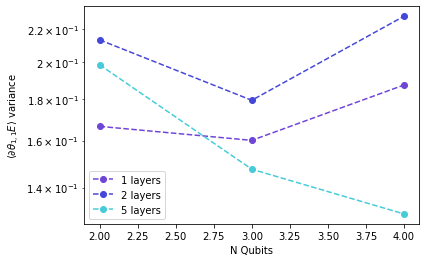

In [184]:
plot_gradients(layers_list, qubits_list, gadget_circuit)